# Third model: TFIDF + complexity features

In [21]:
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

In [22]:
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import gc

In [23]:
df = pd.read_csv('~/TFM_fake_news_detector/data/corpus_features.csv', index_col = 0)

In [24]:
y = df['Category']

In [25]:
df_index = df.index

## TfidfVectorizer

The TfidfVectorizer serves us to convert a collection of raw documents into a matrix of TF and IDF features.

### IDF (Inverse Document Frequency)

The IDF is used to calculate how many times a word appears on a set of documents.

### TF (Term Frequency)

The TF, unlike the IDF is the number of times a word appears in a single document.

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [26]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

In [27]:
#Spanish stemmer: Stemming is the process to transform any word into its rooting word, considering them as the same word
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [28]:
#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

In [29]:
def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [30]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

### Transformation

In [31]:
text_vectorized = tfidf_vectorizer.fit_transform(df['Text']) 

In [32]:
tfvocab = tfidf_vectorizer.get_feature_names()

### Make Dense dataframe Sparse, and Combine with TF-IDF features

In [33]:
categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

X = hstack([csr_matrix(df[categorical_features].values), text_vectorized[0:]])
tfvocab = df.columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
gc.collect();

971 Rows and 15569 Cols
Feature Names Length:  15576


In [201]:
# X = hstack([
#     text_vectorized,
#     csr_matrix(df[categorical_features].loc[df_index,].values)], 'csr'
# )
# print("train shape: {} rows, {}".format(*X.shape))

### Split in training and test for validation

In [34]:
# Calculating level of imbalance for future models.
imbalance_weight = y.value_counts(normalize=True)[0] / y.value_counts(normalize=True)[1]
print("Imbalance Weight: ", imbalance_weight)

Imbalance Weight:  1.0229166666666665


In [35]:
# Training and Validation Set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 23)

In [36]:
# XGBOOST Sparse Feature Storage
d_train = xgb.DMatrix(X_train, y_train, feature_names = tfvocab)
d_test = xgb.DMatrix(X_test, y_test, feature_names = tfvocab)

TypeError: must be real number, not str

## Model: XGB

In [37]:
xgb_params = {'eta': 0.05, 
              'max_depth': 12, 
              'subsample': 0.8, 
              'colsample_bytree': 0.75,
              #'min_child_weight' : 1.5,
              'scale_pos_weight': imbalance_weight,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 1.5,
              'alpha': .6
             }

In [ ]:
modelstart = time.time()
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 2000, watchlist, verbose_eval=50, early_stopping_rounds=50)
xgb_pred = model.predict(d_test)

xgb_sub = pd.DataFrame(xgb_pred,columns=["project_is_approved"],index=tesdex)
xgb_sub.to_csv("xgb_sub.csv",index=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

del d_train, d_valid, d_test
gc.collect();

In [16]:
pa_classifier = PassiveAggressiveClassifier(max_iter=50)
pa_classifier.fit(X_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

## Predictions & results

In [71]:
y_pred = pa_classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 57.53%


In [72]:
cf_matrix = confusion_matrix(y_test,y_pred, labels = ['Fake','True'])
print(cf_matrix)

[[ 24 116]
 [  8 144]]


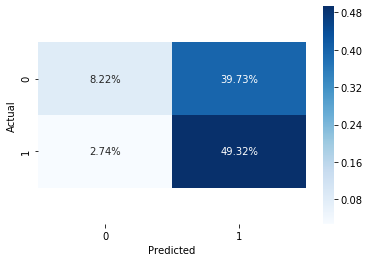

In [73]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()